# Evaluation

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
from gensim import corpora, models
import pickle

# from sklearn.datasets import fetch_20newsgroups

# from collections import defaultdict
# import re
# from string import punctuation

In [2]:
with open("preprocessed_text/test_data484.pkl", 'rb') as f:
    loaded_preprocessed_paper_text_list = pickle.load(f)

In [3]:
dictionary = corpora.Dictionary(loaded_preprocessed_paper_text_list)

In [4]:
dictionary.filter_extremes(no_below=50, no_above=0.5)

In [5]:
test_corpus = [dictionary.doc2bow(doc) for doc in loaded_preprocessed_paper_text_list]

In [6]:
len(test_corpus)

484

In [7]:
tfidf = models.TfidfModel(test_corpus)

In [8]:
corpus_tfidf = tfidf[test_corpus]

## Retrieve Model

In [9]:
from pathlib import Path
import os
import sys

# Adjust the number of parent calls based on the nesting level
root_path = str(Path(os.getcwd()).resolve().parent)  
sys.path.append(root_path)

import model

Load the model from a file

In [10]:
with open("trained_model/nips_1935_iteration_100.pkl", 'rb') as f:
    loaded_model = pickle.load(f)

## Coherence Score

In [11]:
from gensim.models.coherencemodel import CoherenceModel

In [12]:
# After you've run Gibbs sampling
word_topic_matrix = loaded_model.word_topic_matrix
word_topic_sum = word_topic_matrix.sum(axis=1)[:, np.newaxis]
word_topic_dist = word_topic_matrix / word_topic_sum

In [13]:
list_of_top_words_number = [5, 10, 15, 20, 25, 30]
list_of_coherence_score = []

In [14]:
def calculate_coherence_score(N_TOP_WORDS = 10):
  # Get the top words for each topic
  ALL_TOPIC_WORDS = []
  for i in range(loaded_model.num_topics):
      top_words_idx = word_topic_dist[i].argsort()[-N_TOP_WORDS:][::-1]
      top_words = [loaded_model.id2word[idx] for idx in top_words_idx]

      ALL_TOPIC_WORDS.append(top_words)

  # Compute Coherence Score
  coherence_model = CoherenceModel(topics=ALL_TOPIC_WORDS, corpus=corpus_tfidf, dictionary=dictionary, coherence='u_mass')

  coherence_score = coherence_model.get_coherence()

  return coherence_score

In [15]:
for number in list_of_top_words_number:
  score = calculate_coherence_score(number)
  list_of_coherence_score.append(score)

In [16]:
list_of_coherence_score

[-0.7135867687903175,
 -0.8332173087217021,
 -0.9103089585340436,
 -0.9515959339748237,
 -1.0159686137886559,
 -0.9758385854544178]

In [17]:
import matplotlib.pyplot as plt

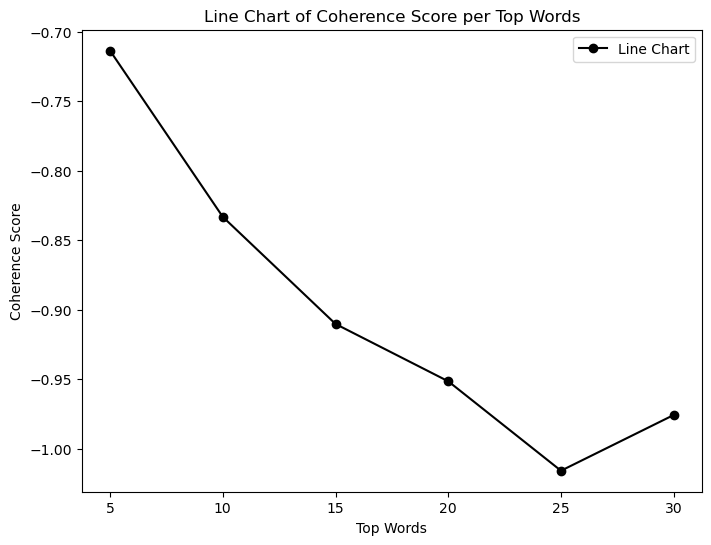

In [18]:
plt.figure(figsize=(8, 6))  # Set the size of the chart (optional)

# Create a line chart using the `plot` function
plt.plot(list_of_top_words_number, list_of_coherence_score, marker='o', linestyle='-', color='black', label='Line Chart')

# Add labels and a title
plt.xlabel('Top Words')
plt.ylabel('Coherence Score')
plt.title('Line Chart of Coherence Score per Top Words')

# Add a legend (if multiple lines are present)
plt.legend()

# Show the chart
plt.show()


## Heatmap

In [19]:
import seaborn as sns

In [20]:
def calculate_theta_update(model):
    return (model.author_topic_matrix + model.a) / (
        model.author_topic_matrix.sum(axis=1)[:, np.newaxis] + model.num_topics * model.a
    )

In [21]:
# Create a normalized author-topic matrix for all authors
normalized_author_topic_matrix = calculate_theta_update(loaded_model)

In [22]:
# Convert to DataFrame for easier plotting
author_names = loaded_model.authors
topic_names = [str(i+1) for i in range(loaded_model.num_topics)]
df = pd.DataFrame(normalized_author_topic_matrix, index=author_names, columns=topic_names)

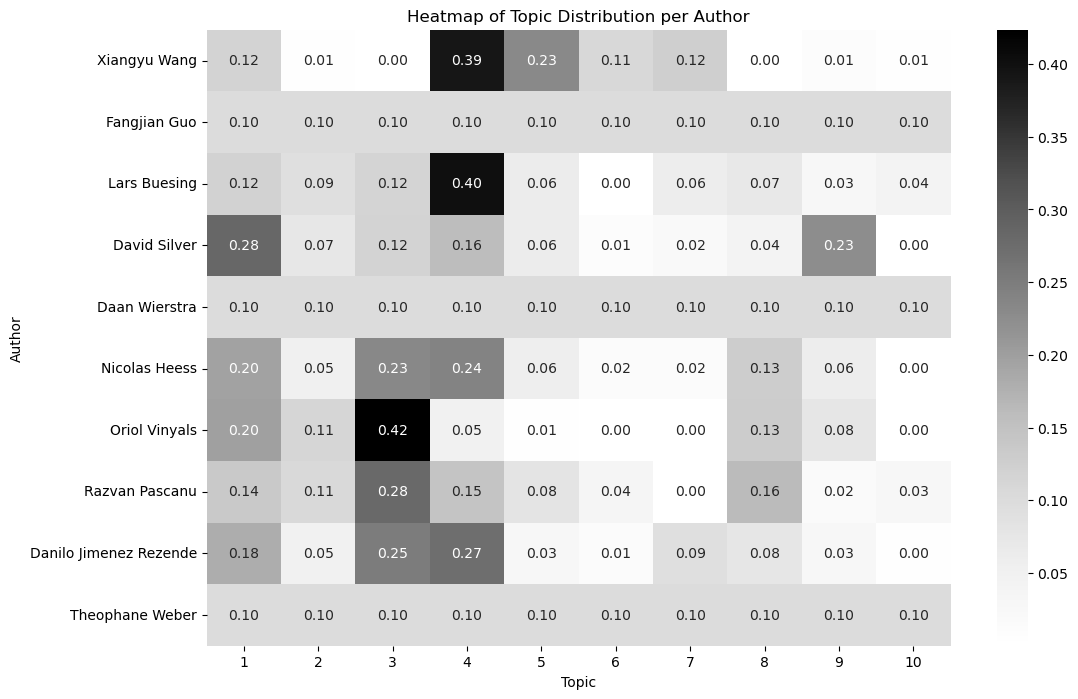

In [23]:
# Plotting the Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[10:20], cmap="Greys", annot=True, fmt=".2f")
plt.title('Heatmap of Topic Distribution per Author')
plt.ylabel('Author')
plt.xlabel('Topic')
plt.show()